In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.animation
import pandas as pd

sns.set_style("darkgrid")
plt.rcParams["animation.html"] = "html5"


In [2]:
class Graph(nx.Graph):
    def random_graph(self, n, p):
        eges_nr = np.sum([i for i in range(n)])
        edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n) if np.random.uniform() < p ])
        # all_edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n)])
        # taked_edes = np.random.uniform(size=eges_nr)<p
        # edges_to_add = all_edges[taked_edes]
        self.add_nodes_from(range(n))
        # self.add_edges_from(edges_to_add)
        self.add_edges_from(edges)
        return self
    
    def Watts_Strogatz_model(self, n , k, p):
        """Returns a Watts–Strogatz small-world graph.

        Parameters
        ----------
        n : int
            The number of nodes
        k : int
            Each node is joined with its `k` nearest neighbors in a ring
            topology.
        p : float
            The probability of rewiring each edge
        """
        if k>n:
            raise ValueError(f"The parameter 'k' = {k} is greater than parametr 'n' = {n}")
        elif k == n:
            return nx.complete_graph(n)
        # g = nx.Graph()
        self.add_nodes_from(range(n))
        
        nodes = self.nodes
        for i in range(n):
            for j in range(1, k // 2 + 1):
                self.add_edge(i, (i+j)%n)
                
        for node in nodes:
            for neighbour in range(1, k // 2 + 1):
                if np.random.uniform() < p:
                    random_note = np.random.choice(nodes)
                    while node == random_note or self.has_edge(node, random_note):
                        random_note = np.random.choice(nodes)
                    else:
                        self.remove_edge(node, (node + neighbour)%n)
                        self.add_edge(node, random_note)
                else:
                    pass
        return self

    def barabasi_albert_model(self, m0, n, iterations, inicial_praph = None):
        if inicial_praph:
            g = inicial_praph
        else:
            g = nx.complete_graph(m0)
        degrees = {note:degre for note,degre in g.degree() }
        for node in range(m0, m0 + iterations):
            values = np.array(list(degrees.values()))
            nodes_to_conect = np.random.choice(list(degrees.keys()), size = n, replace=False, p = values/sum(values))
            degrees[node] = n
            for node_to_conect in nodes_to_conect:
                degrees[node_to_conect] += 1
            g.add_edges_from([[node, i] for i in nodes_to_conect ])
        return g
        
    def lattice_2d(m, n):
        g = nx.grid_2d_graph(m, n)
        return g

In [139]:
def SIR_model_on_a_network_continued(graph, p, I_0 = None):
    nx.set_node_attributes(graph, "S", "status")
    if not I_0:
        infecteds = [random.choice(list(graph.nodes))]
    elif type(I_0) == int:
        nodes_id = np.random.choice(range(len(graph.nodes)), size=I_0, replace = False)
        infecteds = [list(graph.nodes)[i] for i in nodes_id]
    elif type(I_0) == list:
        infecteds = I_0
    infections = len(infecteds)
    iteration = 0
    max_iteration = len(graph.degree)
    for I in infecteds:
        graph.nodes[I]["status"] = "I"
    history = [graph.copy()]
    while iteration < max_iteration:
        while infecteds:
            new_infecteds = []
            for I in infecteds:
                for neighbors in graph.neighbors(I):
                    if np.random.uniform() < p:
                        if graph.nodes[neighbors]["status"] == "S":
                            graph.nodes[neighbors]["status"] = "I"
                            infections += 1
                            new_infecteds.append(neighbors)
            for I in infecteds:
                graph.nodes[I]["status"] = "R"
            infecteds = new_infecteds
            history.append(graph.copy())
        
        while iteration < max_iteration:
            random_index = np.random.randint(max_iteration)
            new_infected = list(graph.nodes(data = "status"))[random_index]
            iteration += 1
            if new_infected[1] == "S":
                infecteds = [new_infected[0]]
                break
    return history

In [141]:
def set_color(x):
    if x == "I":
        return "red"
    elif x == "S":
        return "blue"
    elif x == "R":
        return "green"

def create_animation(moves_history, pos, filename):
    fig, ax = plt.subplots(figsize = (5,5))

    def animate(i, moves_history):
        ax.cla()
        g = moves_history[i]
        labels = nx.get_node_attributes(g, 'status') 
        colors = [set_color(labels[i]) for i in labels]
        nx.draw_networkx(g, pos, node_color = colors, ax=ax)
        return ax,
    
    anim = matplotlib.animation.FuncAnimation(fig, animate , fargs = [moves_history], frames=len(moves_history))
    anim
    anim.save(filename)

70

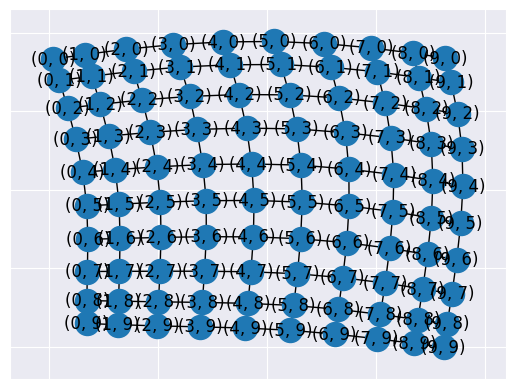

In [142]:
n = 10
g1 = Graph.lattice_2d(n,n)
pos = nx.spring_layout(g1, seed=3)
nx.draw_networkx(g1, pos)
moves_history = SIR_model_on_a_network_continued(g1, 0.3, I_0 = 1)
len(moves_history)

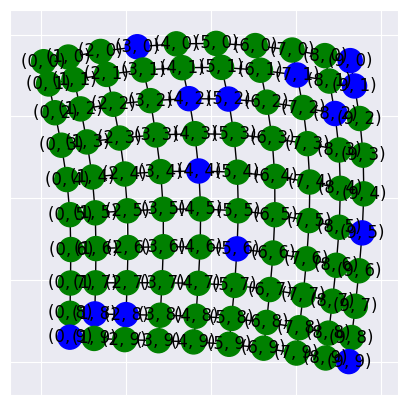

In [143]:
create_animation(moves_history, pos,"lattice_2d_continued_anim.gif")

### random graph

14

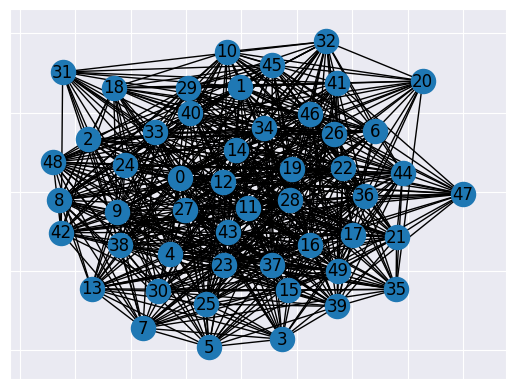

In [144]:
N = 100
N = 50
p = 0.5
g2 = Graph().random_graph(N, p)
# pos = nx.circular_layout(g2)
pos = nx.spring_layout(g2, seed=3)

nx.draw_networkx(g2, pos)
moves_history_random_graph = SIR_model_on_a_network_continued(g2, 0.1, I_0 = 1)
len(moves_history_random_graph)

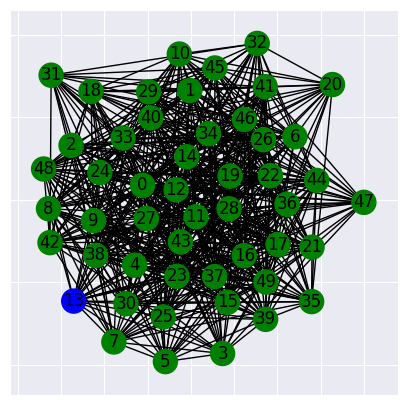

In [145]:
create_animation(moves_history_random_graph, pos,"random_graph_continued_anim.gif")

### Watts-Strogatz graph

48

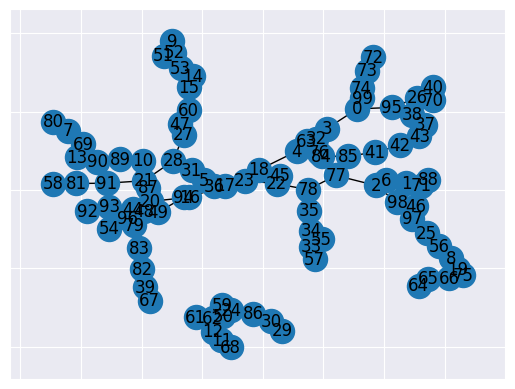

In [146]:
N = 100
K = 2
p = 0.6
g3 = Graph().Watts_Strogatz_model(N, K, p)
pos = nx.spring_layout(g3)

nx.draw_networkx(g3, pos)
moves_history_Watts_Strogatz = SIR_model_on_a_network_continued(g3, 0.9, I_0 = 1)
len(moves_history_Watts_Strogatz)

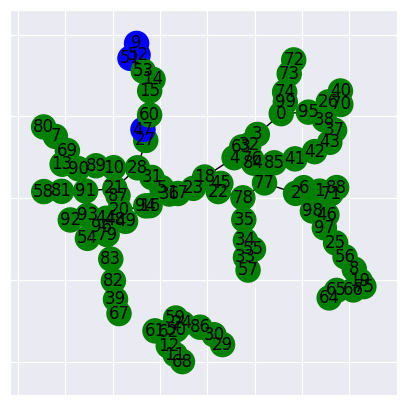

In [147]:
create_animation(moves_history_Watts_Strogatz, pos, "Watts_Strogatz_continued_anim.gif")

###  Barabasi-Albert graph

67

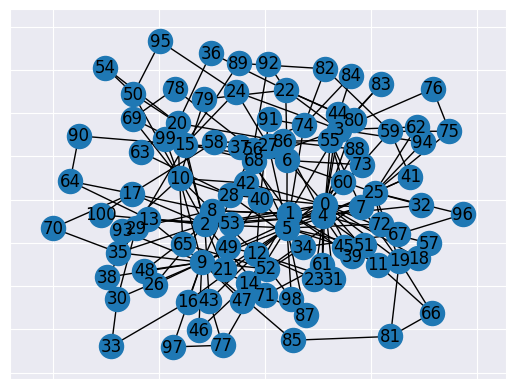

In [148]:
m0 = 3
n = 2
iterations  = 98
g4 = Graph().barabasi_albert_model(m0, n, iterations = iterations)
pos = nx.spring_layout(g4)
# pos = nx.circular_layout(g4)
nx.draw_networkx(g4, pos)
moves_history_Barabasi_Albert = SIR_model_on_a_network_continued(g3, 0.8, I_0 = 1)
len(moves_history_Barabasi_Albert)

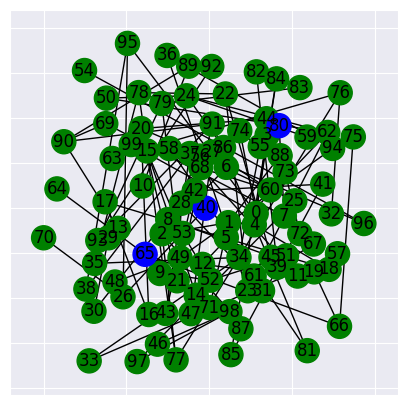

In [149]:
create_animation(moves_history_Barabasi_Albert, pos, "Barabasi_Albert_continued_anim.gif")

## 2)  Record the fraction of infected nodes in the network at each time point for three different values of p
Record the fraction of infected nodes in the network at each time point for three different values of p. Because the SIR dynamics is stochastic, you will want to simulate each infection multiple times with the same starting node. Plot the average of this runs over time for each value of p.

In [150]:
def infected_sym(graph, ps, MC, I_0 = 1):
    end_dfs_R = []
    end_dfs_I = []
    times = len(g1.degree)
    for p in ps:
        all_results_R = np.zeros((times + 1, MC))
        all_results_I = np.zeros((times + 1, MC))

        for i in range(MC):
            moves_history = SIR_model_on_a_network_continued(graph, p, I_0 = I_0)
            results_R  = list(map(lambda x: sum([status == "R" for status in nx.get_node_attributes(x, 'status').values()] ), moves_history))
            if len(results_R) != times + 1:
                results_R = results_R + [results_R[-1]]*(times - len(results_R) + 1)
            all_results_R[:,i] = results_R
            
            results_I  = list(map(lambda x: sum([status == "I" for status in nx.get_node_attributes(x, 'status').values()] ), moves_history))
            if len(results_I) != times + 1:
                results_I = results_I + [results_I[-1]]*(times - len(results_I) + 1)
            all_results_I[:,i] = results_I
            
        df_R = pd.DataFrame(all_results_R)
        df_R["x"] = np.arange(0,times+1)
        df_R["p"] = p
        end_dfs_R.append(df_R)
        
        df_I = pd.DataFrame(all_results_I)
        df_I["x"] = np.arange(0,times+1)
        df_I["p"] = p
        end_dfs_I.append(df_I)
    return [end_dfs_R, end_dfs_I]

### 2D lattice

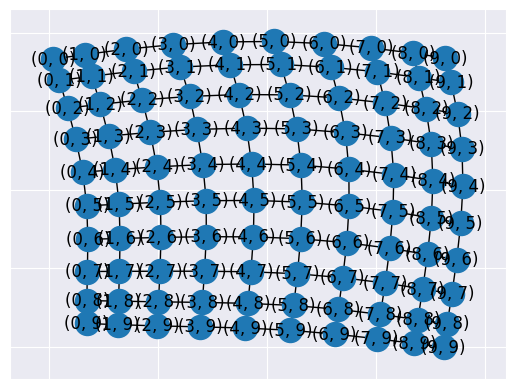

In [151]:
n = 10
g1 = Graph.lattice_2d(n,n)
pos = nx.spring_layout(g1, seed=3)
nx.draw_networkx(g1, pos)

In [152]:
pn = 10
MC = 100

ps = np.linspace(0.1, 0.99, pn)
end_dfs_R, end_dfs_I = infected_sym(g1, ps, MC, I_0 = [(4,4)])

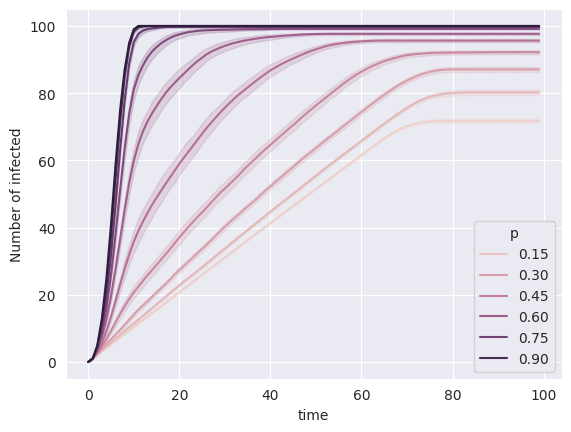

In [153]:
x_lim = 100
end_df = end_dfs_R[0]
for i in range(1, len(end_dfs_R)):
    end_df = pd.concat([end_df, end_dfs_R[i]])
end_df["p"] = end_df["p"].round(2)
end_df = end_df.loc[range(x_lim)]
plot = sns.lineplot(end_df.melt(["x","p"]), x = "x", y = "value", hue = "p")
plt.ylabel("Number of infected")
plt.xlabel("time")
plt.show()

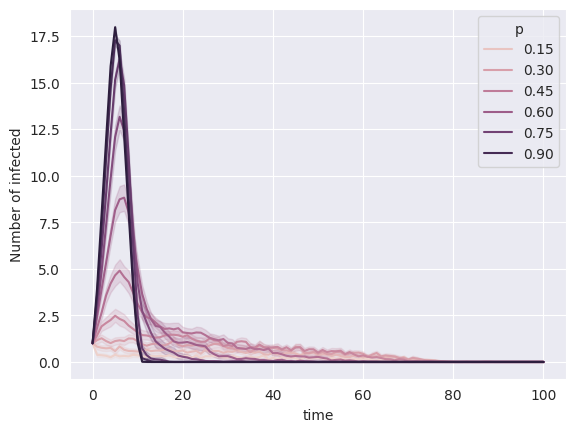

In [154]:
end_df = end_dfs_I[0]
for i in range(1, len(end_dfs_I)):
    end_df = pd.concat([end_df, end_dfs_I[i]])
end_df["p"] = end_df["p"].round(2)
plot = sns.lineplot(end_df.melt(["x","p"]), x = "x", y = "value", hue = "p")
plt.ylabel("Number of infected")
plt.xlabel("time")
plt.show()

### random graph

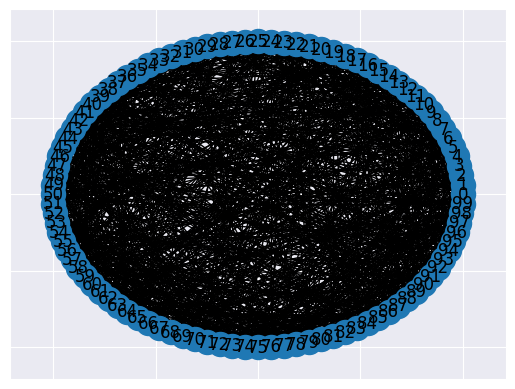

In [155]:
N = 100
p_graph = 0.2
g2 = Graph().random_graph(N, p_graph)
pos = nx.circular_layout(g2)
nx.draw_networkx(g2, pos)

In [156]:
MC = 100
pn = 10
ps = np.linspace(0.1, 0.99, pn)
end_dfs_R, end_dfs_I  = infected_sym(g2, ps, MC, I_0 = [0])

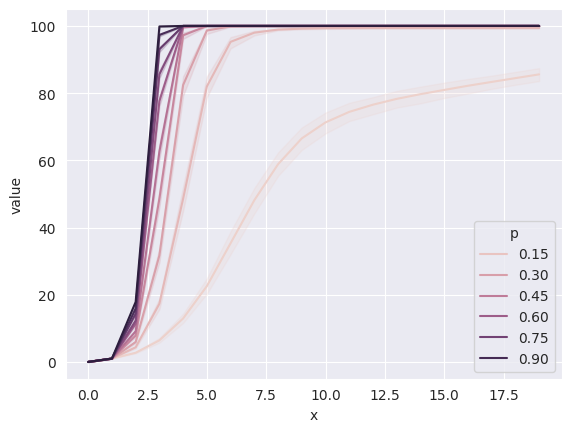

In [158]:
x_lim = 30
end_df = end_dfs_R[0]
for i in range(1, len(end_dfs_R)):
    end_df = pd.concat([end_df, end_dfs_R[i]])
end_df["p"] = end_df["p"].round(x_lim)
end_df = end_df.loc[range(20)]
plot = sns.lineplot(end_df.melt(["x","p"]), x = "x", y = "value", hue = "p" )
plt.show()

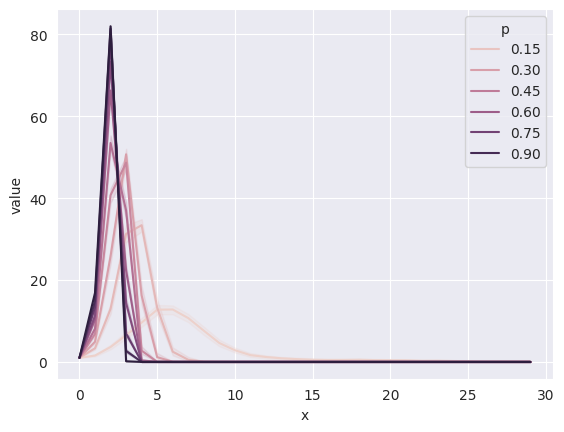

In [159]:
end_df = end_dfs_I[0]
for i in range(1, len(end_dfs_I)):
    end_df = pd.concat([end_df, end_dfs_I[i]])
end_df["p"] = end_df["p"].round(2)
end_df = end_df.loc[range(x_lim)]
plot = sns.lineplot(end_df.melt(["x","p"]), x = "x", y = "value", hue = "p" )
plt.show()

### Watts-Strogatz graph

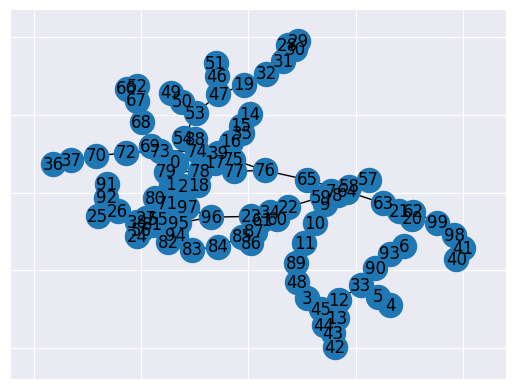

In [166]:
N = 100
K = 2
p = 0.4
g3 = Graph().Watts_Strogatz_model(N, K, p)
pos = nx.spring_layout(g3)

nx.draw_networkx(g3, pos)

In [167]:
MC = 100
times = 40
pn = 10

ps = np.linspace(0.1, 0.99, pn)
end_dfs_R, end_dfs_I = infected_sym(g3, ps, MC, I_0 = [0])

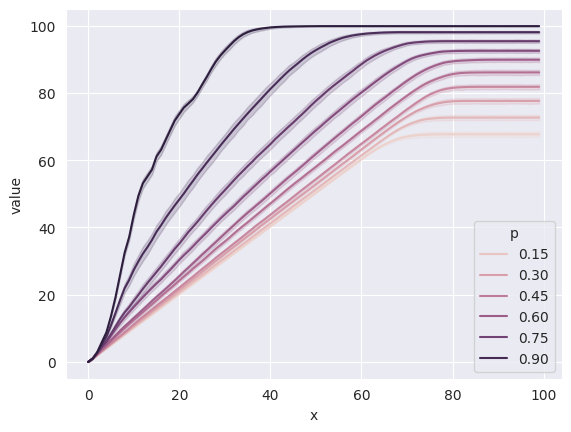

In [168]:
x_lim = 100
end_df = end_dfs_R[0]
for i in range(1, len(end_dfs_R)):
    end_df = pd.concat([end_df, end_dfs_R[i]])
end_df["p"] = end_df["p"].round(2)
end_df = end_df.loc[range(x_lim)]
plot = sns.lineplot(end_df.melt(["x","p"]), x = "x", y = "value", hue = "p" )
plt.show()

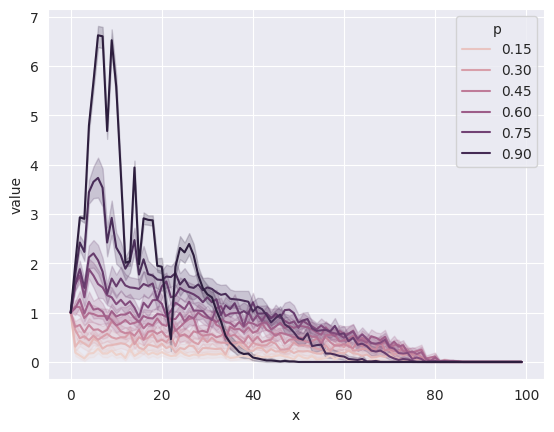

In [169]:
end_df = end_dfs_I[0]
for i in range(1, len(end_dfs_I)):
    end_df = pd.concat([end_df, end_dfs_I[i]])
end_df["p"] = end_df["p"].round(2)
end_df = end_df.loc[range(x_lim)]
plot = sns.lineplot(end_df.melt(["x","p"]), x = "x", y = "value", hue = "p" )
plt.show()

###  Barabasi-Albert graph

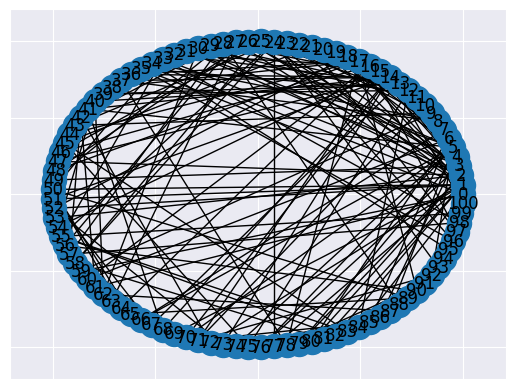

In [170]:
m0 = 3
n = 2
iterations  = 98
g4 = Graph().barabasi_albert_model(m0, n, iterations = iterations)
pos = nx.circular_layout(g4)
nx.draw_networkx(g4, pos)

In [171]:
MC = 150
pn = 10
ps = np.linspace(0.1, 0.99, pn)
end_dfs_R, end_dfs_I  = infected_sym(g4, ps, MC, I_0 = [0])

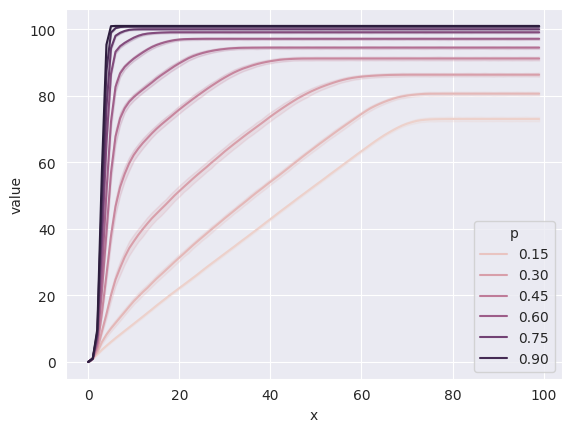

In [177]:
x_lim = 100
end_df = end_dfs_R[0]
for i in range(1, len(end_dfs_R)):
    end_df = pd.concat([end_df, end_dfs_R[i]])
end_df["p"] = end_df["p"].round(2)
end_df = end_df.loc[range(x_lim)]
plot = sns.lineplot(end_df.melt(["x","p"]), x = "x", y = "value", hue = "p" )
plt.show()

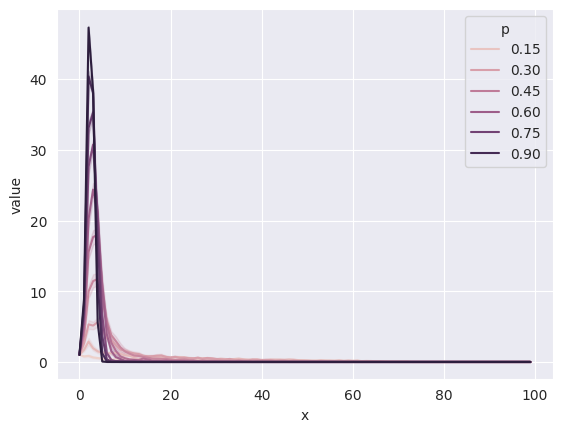

In [178]:
end_df = end_dfs_I[0]
for i in range(1, len(end_dfs_I)):
    end_df = pd.concat([end_df, end_dfs_I[i]])
end_df["p"] = end_df["p"].round(2)
end_df = end_df.loc[range(x_lim)]
plot = sns.lineplot(end_df.melt(["x","p"]), x = "x", y = "value", hue = "p" )
plt.show()

## Discuss how the infection curves compare to the behavior seen in the ODE model

## Now select at least 20 different values of p. Simulate the SIR dynamics on the network starting with a random node.
Measure the totalpropotion of the network that becomes infected, the time to clear
infection and the time to the largest number of infected nodes. Be
sure to simulate the infection enough times (each run starting from
a different randomly chosen starting node) that you can reasonably
estimate the mean of each of these measures. For each measure plot
it as a function of p. Make one plot for each measure, including a
separate line (labeled appropriately) for each network.

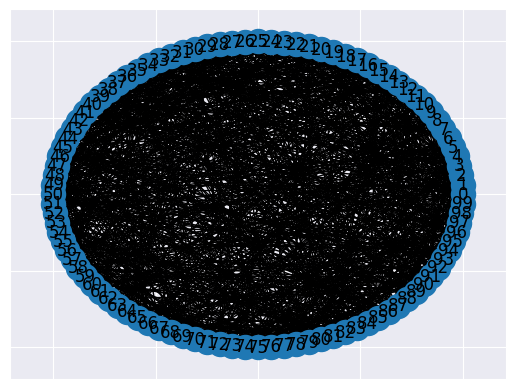

In [180]:
N = 100
p_graph = 0.2
g2 = Graph().random_graph(N, p_graph)
pos = nx.circular_layout(g2)
nx.draw_networkx(g2, pos)

In [193]:
MC = 100
pn = 20
ps = np.linspace(0.01, 0.99, pn)
end_dfs_R, end_dfs_I = infected_sym(g2, ps, MC, I_0 = 1)

In [194]:
x_lim = 20
col_names = np.arange(MC)
df = pd.DataFrame(columns=["min_hit_times", "max_hit_times", "p"])
for pi in range(x_lim):
    data_ftame_I = end_dfs_I[pi]
    data_ftame_R = end_dfs_R[pi]
    min_hit_time = []    
    for i, row in data_ftame_I[col_names].iterrows():
        if any(row == 0):
            min_hit_time.extend([i]*(sum(row == 0) - len(min_hit_time)))
    max_hit_time = data_ftame_I[col_names].idxmax()
    _df = pd.DataFrame(np.array([min_hit_time, max_hit_time, [ps[pi]]*MC]).T , columns=["min_hit_times", "max_hit_times", "p"])
    df = pd.concat([df, _df])

Text(0.5, 0, 'p')

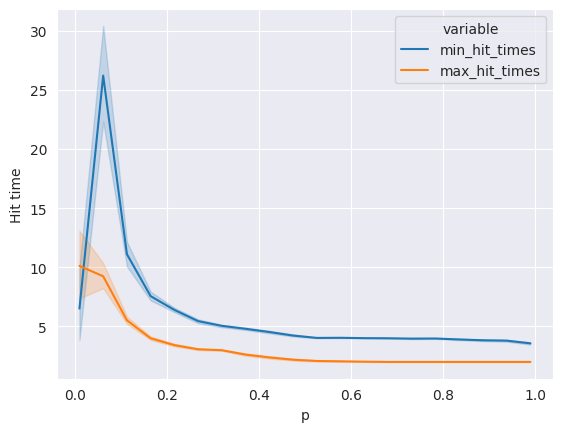

In [195]:
ax = sns.lineplot(df.melt("p"), x= "p", y = "value", hue="variable")
ax.set_ylabel("Hit time")
ax.set_xlabel("p")

In [196]:
col_names = np.arange(MC)
df = pd.DataFrame(columns=["proportion", "p"])
for pi in range(x_lim):
    data_ftame_R = end_dfs_R[pi]
    proportions = data_ftame_R[col_names].iloc[-1]
    _df = pd.DataFrame(np.array([proportions, [ps[pi]]*MC]).T , columns=["proportion", "p"])
    df = pd.concat([df, _df])

Text(0.5, 0, 'p')

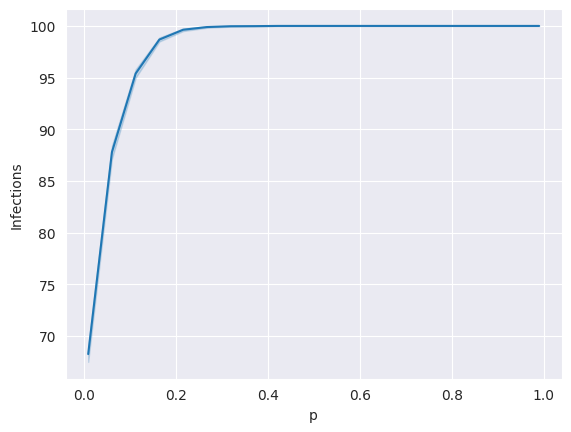

In [197]:
ax = sns.lineplot(df.melt("p"), x= "p", y = "value")
ax.set_ylabel("Infections")
ax.set_xlabel("p")